# Identify Fraud in the Enron Dataset
## Final Project - David Manasco



In [1]:
#!/usr/bin/python
import pandas as pd
import sys
import pickle
import csv
import matplotlib.pyplot as plt


sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from poi_data import *
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import StratifiedShuffleSplit
from numpy import mean
from sklearn import cross_validation
from sklearn.metrics import accuracy_score, precision_score, recall_score



/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
############# Task 1: Select what features you'll use.############

target_label = 'poi'
email_features_list = [
    'from_messages',
    'from_poi_to_this_person',
    'from_this_person_to_poi',
    'shared_receipt_with_poi',
    'to_messages',
    ]
financial_features_list = [
    'bonus',
    'deferral_payments',
    'deferred_income',
    'director_fees',
    'exercised_stock_options',
    'expenses',
    'loan_advances',
    'long_term_incentive',
    'other',
    'restricted_stock',
    'restricted_stock_deferred',
    'salary',
    'total_payments',
    'total_stock_value',
]

features_list = [target_label] + financial_features_list + email_features_list

In [3]:
data_dict = pickle.load(open("final_project_dataset.pkl", "r") )


print('# Exploratory Data Analysis #')
data_dict.keys()
print('Total number of data points: %d' % len(data_dict.keys()))
num_poi = 0
for name in data_dict.keys():
    if data_dict[name]['poi'] == True:
        num_poi += 1
print('Number of Persons of Interest: %d' % num_poi)
print('Number of people without Person of Interest label: %d' % (len(data_dict.keys()) - num_poi))

# Exploratory Data Analysis #
Total number of data points: 146
Number of Persons of Interest: 18
Number of people without Person of Interest label: 128


In [4]:
all_features = data_dict['ALLEN PHILLIP K'].keys()
print('Each person has %d features available' %  len(all_features))
missing_values = {}
for feature in all_features:
    missing_values[feature] = 0
for person in data_dict.keys():
    records = 0
    for feature in all_features:
        if data_dict[person][feature] == 'NaN':
            missing_values[feature] += 1
        else:
            records += 1


Each person has 21 features available


In [5]:
print('Number of Missing Values for Each Feature:')
for feature in all_features:
    print("%s: %d" % (feature, missing_values[feature]))

data_dict = fix_records(data_dict)

Number of Missing Values for Each Feature:
salary: 51
to_messages: 60
deferral_payments: 107
total_payments: 21
exercised_stock_options: 44
bonus: 64
restricted_stock: 36
shared_receipt_with_poi: 60
restricted_stock_deferred: 128
total_stock_value: 20
expenses: 51
loan_advances: 142
from_messages: 60
other: 53
from_this_person_to_poi: 60
poi: 0
director_fees: 129
deferred_income: 97
long_term_incentive: 80
email_address: 35
from_poi_to_this_person: 60


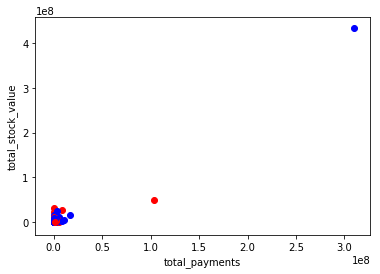

None


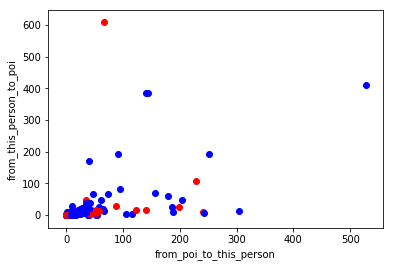

None


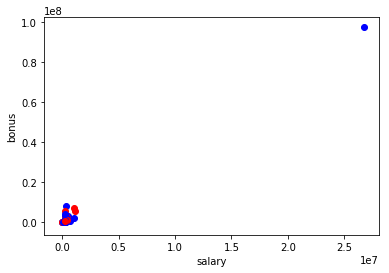

None


In [6]:
################# Task 2: Remove outliers #####################

def PlotOutlier(data_dict, feature_x, feature_y):
    """ Plot with flag = True in Red """
    data = featureFormat(data_dict, [feature_x, feature_y, 'poi'])
    for point in data:
        x = point[0]
        y = point[1]
        poi = point[2]
        if poi:
            color = 'red'
        else:
            color = 'blue'
        plt.scatter(x, y, color=color)
    plt.xlabel(feature_x)
    plt.ylabel(feature_y)
    plt.show()

# 2.1 Visualise outliers
print(PlotOutlier(data_dict, 'total_payments', 'total_stock_value'))
print(PlotOutlier(data_dict, 'from_poi_to_this_person', 'from_this_person_to_poi'))
print(PlotOutlier(data_dict, 'salary', 'bonus'))

In [7]:
def remove_outlier(dict_object, keys):
    """ removes list of outliers keys from dict object """
    for key in keys:
        dict_object.pop(key, 0)

outliers = ['TOTAL', 'THE TRAVEL AGENCY IN THE PARK', 'LOCKHART EUGENE E']
remove_outlier(data_dict, outliers)

In [8]:
################ Task 3: Create new feature(s) ####################
my_dataset = data_dict

def compute_fraction(poi_messages, all_messages):
    """ return fraction of messages from/to that person to/from POI"""    
    if poi_messages == 'NaN' or all_messages == 'NaN':
        return 0.
    fraction = float(poi_messages) / float(all_messages)
    return fraction*100

In [9]:
for name in my_dataset:
    data_point = my_dataset[name]
    data_point["fraction_from_poi"] = compute_fraction(data_point["from_poi_to_this_person"], data_point["to_messages"])
    data_point["fraction_to_poi"] = compute_fraction(data_point["from_this_person_to_poi"], data_point["from_messages"])
    data_point["combined_poi_communications"] = data_point["fraction_from_poi"] + data_point["fraction_to_poi"]

In [10]:
my_feature_list = features_list+['to_messages', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi',
                                 'shared_receipt_with_poi', 'fraction_from_poi', 'fraction_to_poi', 'combined_poi_communications']

In [11]:
num_features = 10

def get_k_best(data_dict, features_list, k):
    """ runs scikit-learn's SelectKBest feature selection
        returns dict where keys=features, values=scores
    """
    data = featureFormat(data_dict, features_list)
    labels, features = targetFeatureSplit(data)

    k_best = SelectKBest(k=k)
    k_best.fit(features, labels)
    scores = k_best.scores_
    unsorted_pairs = zip(features_list[1:], scores)
    sorted_pairs = list(reversed(sorted(unsorted_pairs, key=lambda x: x[1])))
    k_best_features = dict(sorted_pairs[:k])
    print "{0} best features: {1}\n".format(k, k_best_features.keys())
    return k_best_features


In [12]:
best_features = get_k_best(my_dataset, my_feature_list, num_features)

10 best features: ['salary', 'total_payments', 'bonus', 'total_stock_value', 'fraction_to_poi', 'exercised_stock_options', 'deferred_income', 'restricted_stock', 'long_term_incentive', 'combined_poi_communications']



In [112]:
best_features

{'bonus': 20.792252047181535,
 'combined_poi_communications': 15.778960003994115,
 'deferred_income': 11.424891485418364,
 'exercised_stock_options': 22.348975407306217,
 'fraction_to_poi': 16.40971254803578,
 'long_term_incentive': 9.922186013189823,
 'restricted_stock': 8.831852742219493,
 'salary': 18.289684043404513,
 'total_payments': 9.283873618427373,
 'total_stock_value': 22.510549090242055}

In [13]:
my_feature_list = [target_label] + best_features.keys()

In [14]:
print "{0} selected features: {1}\n".format(len(my_feature_list) - 1, my_feature_list[1:])

10 selected features: ['salary', 'total_payments', 'bonus', 'total_stock_value', 'fraction_to_poi', 'exercised_stock_options', 'deferred_income', 'restricted_stock', 'long_term_incentive', 'combined_poi_communications']



In [15]:
data = featureFormat(my_dataset, my_feature_list)
labels, features = targetFeatureSplit(data)

In [16]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
features = scaler.fit_transform(features)

In [17]:
from sklearn.linear_model import LogisticRegression

l_clf = Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(tol = 0.001, C = 10**-8, penalty = 'l2', random_state = 42))])

In [18]:
from sklearn.cluster import KMeans
k_clf = KMeans(n_clusters=2, tol=0.001)

In [19]:
from sklearn.svm import SVC
s_clf = SVC(kernel='rbf', C=1000,gamma = 0.0001,random_state = 42,class_weight='balanced')

In [77]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(max_depth = 2,max_features = 'sqrt',n_estimators = 10, random_state = 42)

In [64]:
def evaluate_clf(clf, features, labels, num_iters=1000, test_size=0.3):
    print clf
    accuracy = []
    precision = []
    recall = []
    first = True
    for trial in range(num_iters):
        features_train, features_test, labels_train, labels_test =\
            cross_validation.train_test_split(features, labels, test_size=test_size)
        clf.fit(features_train, labels_train)
        predictions = clf.predict(features_test)
        accuracy.append(accuracy_score(labels_test, predictions))
        precision.append(precision_score(labels_test, predictions))
        recall.append(recall_score(labels_test, predictions))
        if trial % 10 == 0:
            if first:
                sys.stdout.write('\nProcessing')
            sys.stdout.write('.')
            sys.stdout.flush()
            first = False

    print "done.\n"
    print "accuracy: {}".format(mean(accuracy))
    print "precision: {}".format(mean(precision))
    print "recall:    {}".format(mean(recall))
    return mean(precision), mean(recall)


In [83]:
### test the diff classifiers
evaluate_clf(l_clf, features, labels)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classifier', LogisticRegression(C=1e-08, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.001,
          verbose=0, warm_start=False))])

Processing....................................................................................................done.

accuracy: 0.812488372093
precision: 0.344665069816
recall:    0.488219444444


(0.34466506981580514, 0.48821944444444443)

In [66]:
evaluate_clf(k_clf, features, labels)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.001, verbose=0)

Processing....................................................................................................done.

accuracy: 0.618813953488
precision: 0.270913088432
recall:    0.453818614719


(0.27091308843194745, 0.45381861471861473)

In [67]:
evaluate_clf(s_clf, features, labels)

SVC(C=1000, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

Processing....................................................................................................done.

accuracy: 0.838
precision: 0.386634709735
recall:    0.422766955267


(0.38663470973470976, 0.4227669552669553)

In [78]:
evaluate_clf(rf_clf, features, labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

Processing....................................................................................................done.

accuracy: 0.867813953488
precision: 0.330805952381
recall:    0.11034527417


(0.33080595238095234, 0.11034527417027416)

In [122]:
from sklearn.neighbors import KNeighborsClassifier
nn_clf = KNeighborsClassifier(n_neighbors=6,algorithm='ball_tree', weights = 'distance', leaf_size = 5)
evaluate_clf(nn_clf, features, labels)

KNeighborsClassifier(algorithm='ball_tree', leaf_size=5, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=6, p=2,
           weights='distance')

Processing....................................................................................................done.

accuracy: 0.850023255814
precision: 0.137522655123
recall:    0.0637603174603


(0.13752265512265513, 0.06376031746031746)

In [123]:
from sklearn.neural_network import MLPClassifier
mpl_clf = MLPClassifier(alpha=1)
evaluate_clf(mpl_clf, features, labels)

MLPClassifier(activation='relu', alpha=1, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

Processing.

/anaconda2/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


...................................................................................................done.

accuracy: 0.881488372093
precision: 0.494683333333
recall:    0.158369083694


(0.49468333333333325, 0.1583690836940837)

In [125]:
from sklearn.ensemble import AdaBoostClassifier
qd_clf = AdaBoostClassifier()
evaluate_clf(qd_clf, features, labels)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

Processing....................................................................................................done.

accuracy: 0.826348837209
precision: 0.273824211899
recall:    0.232855772006


(0.27382421189921197, 0.23285577200577198)

In [129]:
l1_clf = Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(tol = 0.00001, C = 0.0002, random_state = 42))])
evaluate_clf(l1_clf, features, labels)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classifier', LogisticRegression(C=0.0002, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
          solver='liblinear', tol=1e-05, verbose=0, warm_start=False))])

Processing....................................................................................................done.

accuracy: 0.81711627907
precision: 0.353005096946
recall:    0.477128643579


(0.3530050969455381, 0.47712864357864354)

In [127]:
clf = l1_clf

In [128]:
# dump your classifier, dataset and features_list so
# anyone can run/check your results
pickle.dump(clf, open("../final_project/my_classifier.pkl", "w"))
pickle.dump(my_dataset, open("../final_project/my_dataset.pkl", "w"))
pickle.dump(my_feature_list, open("../final_project/my_feature_list.pkl", "w"))